
===== Test 1: Stable → Drift =====


/var/tmp/ipykernel_19549/1331526382.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)


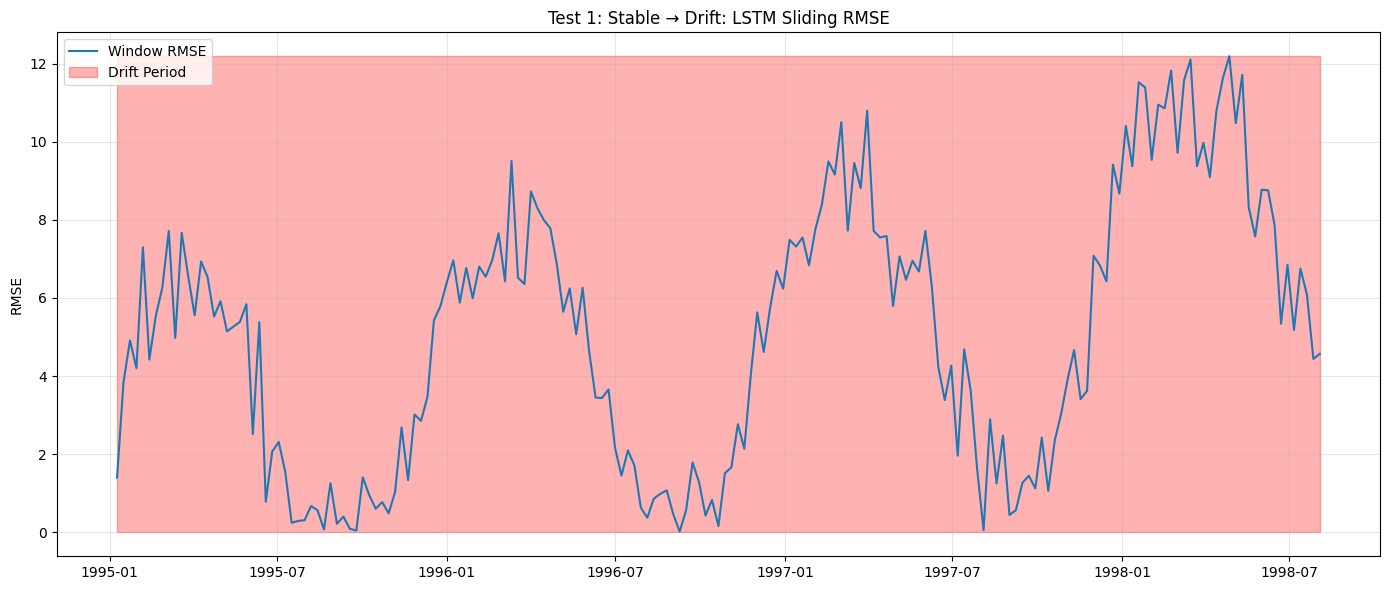

Stable RMSE: 0.153
Drift RMSE: 5.106
Robustness Ratio (Drift/Stable): 33.422

===== Test 2: Balanced Mix =====


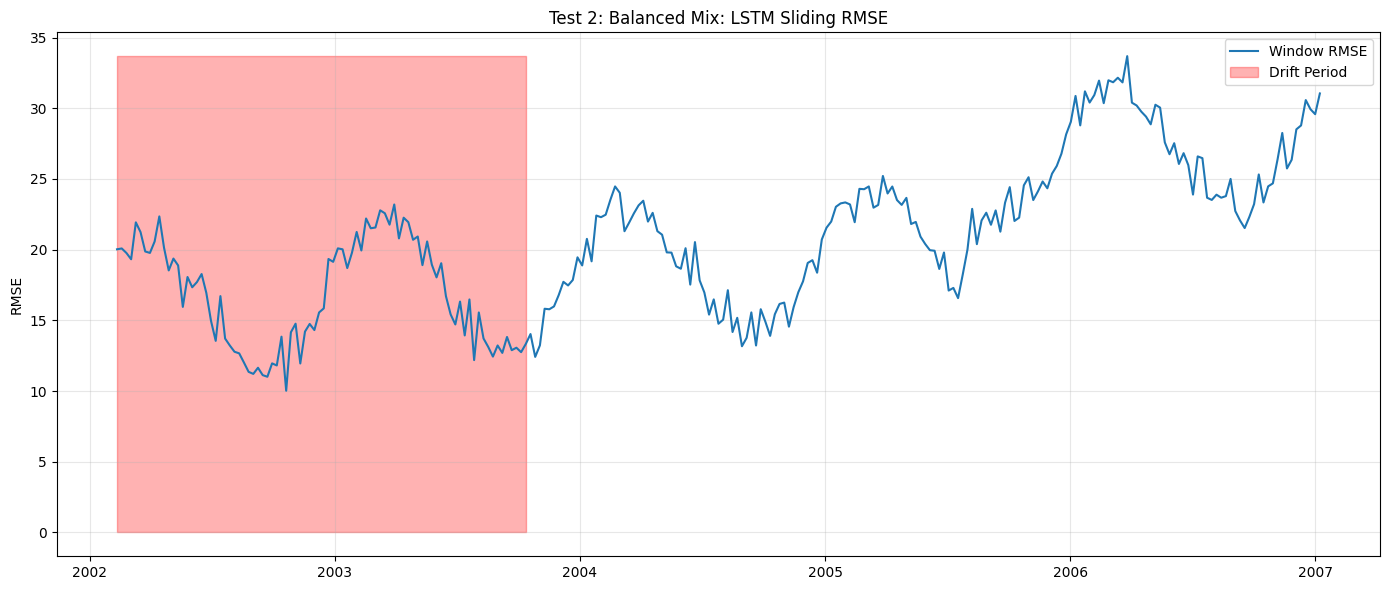

Stable RMSE: 22.521
Drift RMSE: 16.862
Robustness Ratio (Drift/Stable): 0.749

===== Test 3: Long Train, Short Inference =====


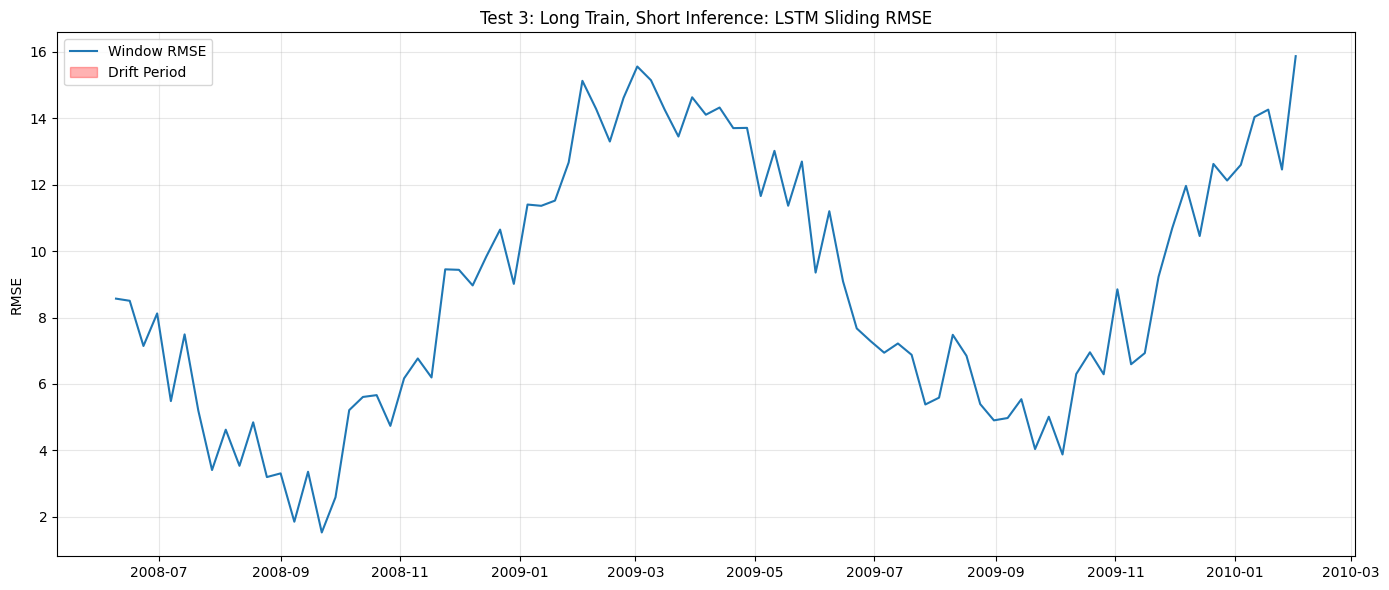

Stable RMSE: 8.795
Drift RMSE: 2.012
Robustness Ratio (Drift/Stable): 0.229

===== Test 4: Stable Only → Long Drift =====


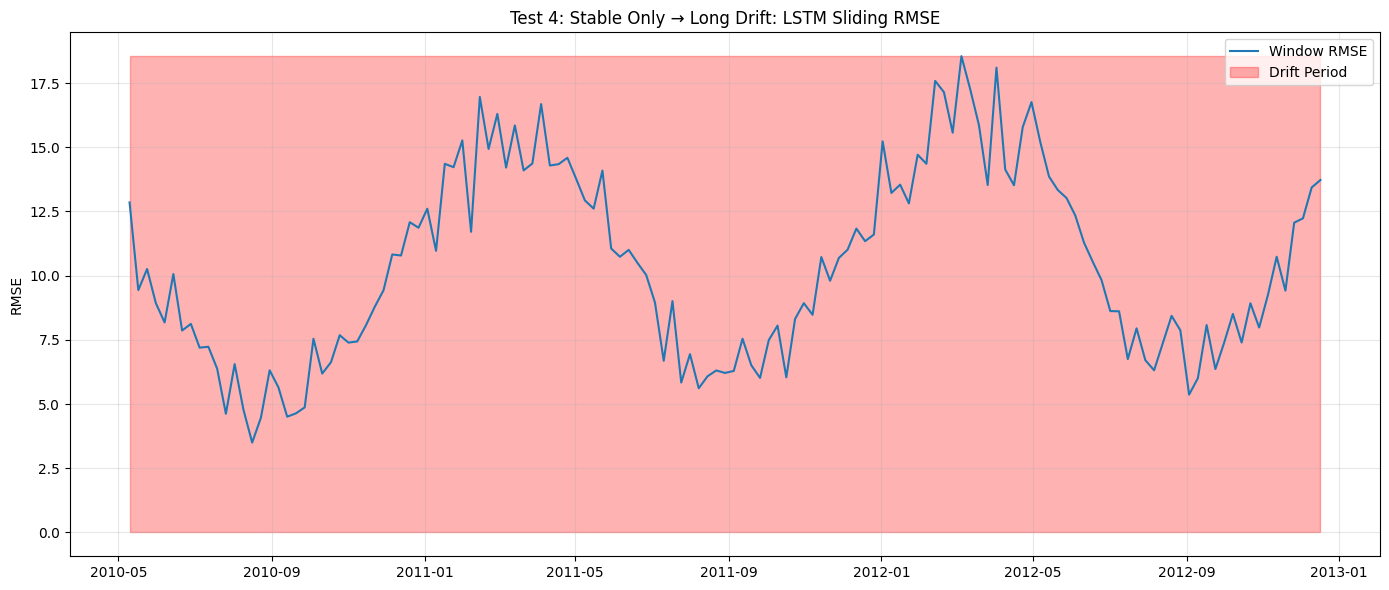

Stable RMSE: 1.675
Drift RMSE: 10.355
Robustness Ratio (Drift/Stable): 6.182

===== Test 5: Rolling Regimes =====


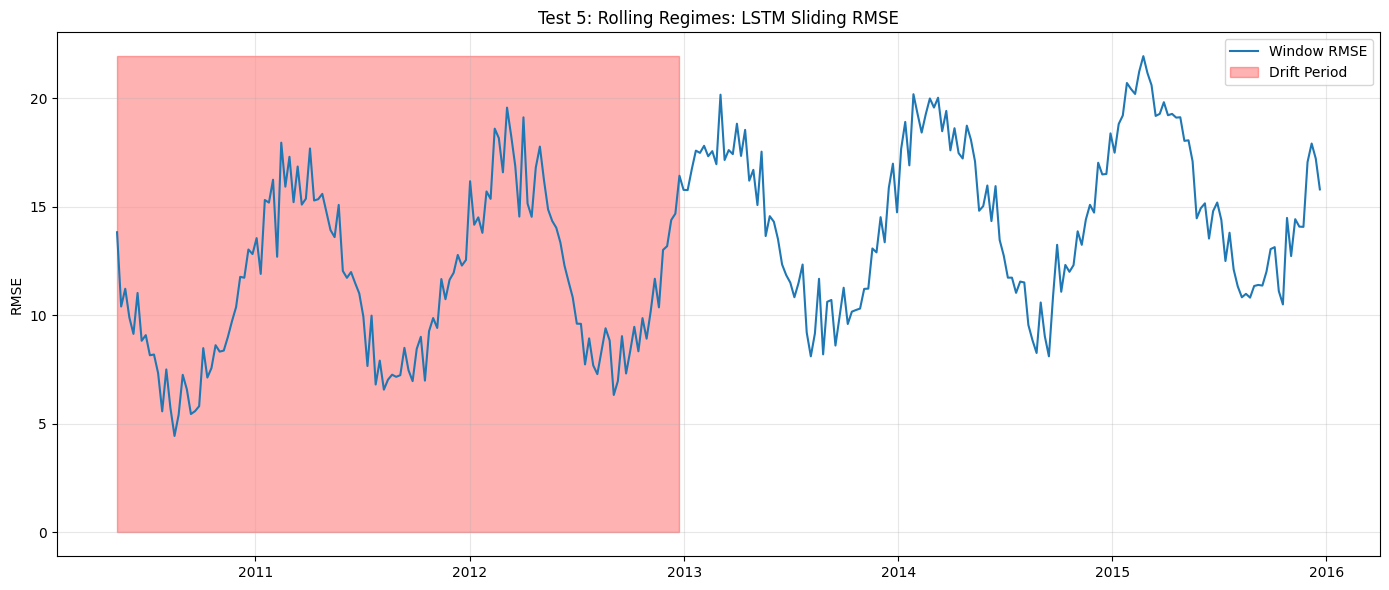

Stable RMSE: 14.859
Drift RMSE: 11.359
Robustness Ratio (Drift/Stable): 0.764


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

df = pd.read_csv('../Data/simulateddata.csv', parse_dates=['date'], index_col='date')
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df.dropna(inplace=True)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

def run_lstm_test(test_name, train_start, train_end, infer_start, infer_end):
    print(f"\n===== {test_name} =====")

    target = 'var1'
    features = [col for col in df.columns if col not in [target, 'drift_period']]
    scaler = StandardScaler()
    X_all = scaler.fit_transform(df[features])
    y_all = df[target].values
    df['scaled_idx'] = np.arange(len(df))

    train_mask = (df.index >= train_start) & (df.index <= train_end)
    infer_mask = (df.index >= infer_start) & (df.index <= infer_end)

    train_idx = df[train_mask]['scaled_idx'].astype(int).values
    infer_idx = df[infer_mask]['scaled_idx'].astype(int).values

    X_train = X_all[train_idx]
    y_train = y_all[train_idx]

    SEQ_LEN = 12
    X_seq_train, y_seq_train = create_sequences(X_train, y_train, SEQ_LEN)

    model = LSTMModel(X_seq_train.shape[2])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_seq_train)
        loss = criterion(y_pred, y_seq_train)
        loss.backward()
        optimizer.step()

    results = []
    for idx in range(infer_idx[0], infer_idx[-1] - SEQ_LEN):
        x_seq = torch.tensor(X_all[idx:idx+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
        y_true = y_all[idx + SEQ_LEN]
        y_pred = model(x_seq).item()
        rmse = np.sqrt((y_pred - y_true) ** 2)
        drift_flag = int(df.iloc[idx + SEQ_LEN]['drift_period'] > 0.5)
        date = df.index[idx + SEQ_LEN]
        results.append({'date': date, 'rmse': rmse, 'is_drift': drift_flag})

    results_df = pd.DataFrame(results).set_index('date')

    stable_rmse = results_df[results_df['is_drift'] == 0]['rmse'].mean()
    drift_rmse = results_df[results_df['is_drift'] == 1]['rmse'].mean()

    if np.isnan(stable_rmse):
        stable_block = train_idx[df.iloc[train_idx]['drift_period'].values == 0]
        if len(stable_block) >= SEQ_LEN + 1:
            x_test = torch.tensor(X_all[stable_block[0]:stable_block[0]+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
            y_true = y_all[stable_block[0] + SEQ_LEN]
            y_pred = model(x_test).item()
            stable_rmse = np.sqrt((y_pred - y_true) ** 2)

    if np.isnan(drift_rmse):
        drift_block = train_idx[df.iloc[train_idx]['drift_period'].values == 1]
        if len(drift_block) >= SEQ_LEN + 1:
            x_test = torch.tensor(X_all[drift_block[0]:drift_block[0]+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
            y_true = y_all[drift_block[0] + SEQ_LEN]
            y_pred = model(x_test).item()
            drift_rmse = np.sqrt((y_pred - y_true) ** 2)

    robustness_ratio = drift_rmse / stable_rmse if stable_rmse > 0 else float('nan')

    plt.figure(figsize=(14, 6))
    plt.plot(results_df.index, results_df['rmse'], label='Window RMSE')
    plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                     where=results_df['is_drift'] == 1, color='red', alpha=0.3, label='Drift Period')
    plt.title(f'{test_name}: LSTM Sliding RMSE')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Stable RMSE: {stable_rmse:.3f}")
    print(f"Drift RMSE: {drift_rmse:.3f}")
    print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")


run_lstm_test("Test 1: Stable → Drift",
              "1990-01-01", "1994-10-10",       
              "1994-10-17", "1998-08-10")       

run_lstm_test("Test 2: Balanced Mix",
              "1994-10-17", "2001-11-12",       
              "2001-11-19", "2007-01-15")      

run_lstm_test("Test 3: Long Train, Short Inference",
              "1990-01-01", "2008-03-10",       
              "2008-03-17", "2010-02-08")    

run_lstm_test("Test 4: Stable Only → Long Drift",
              "1990-01-01", "2010-02-08",
              "2010-02-15", "2012-12-24")       

run_lstm_test("Test 5: Rolling Regimes",
              "1990-01-01", "2010-02-08",      
              "2010-02-15", "2015-12-28")      





===== Test 1: Stable → Drift =====


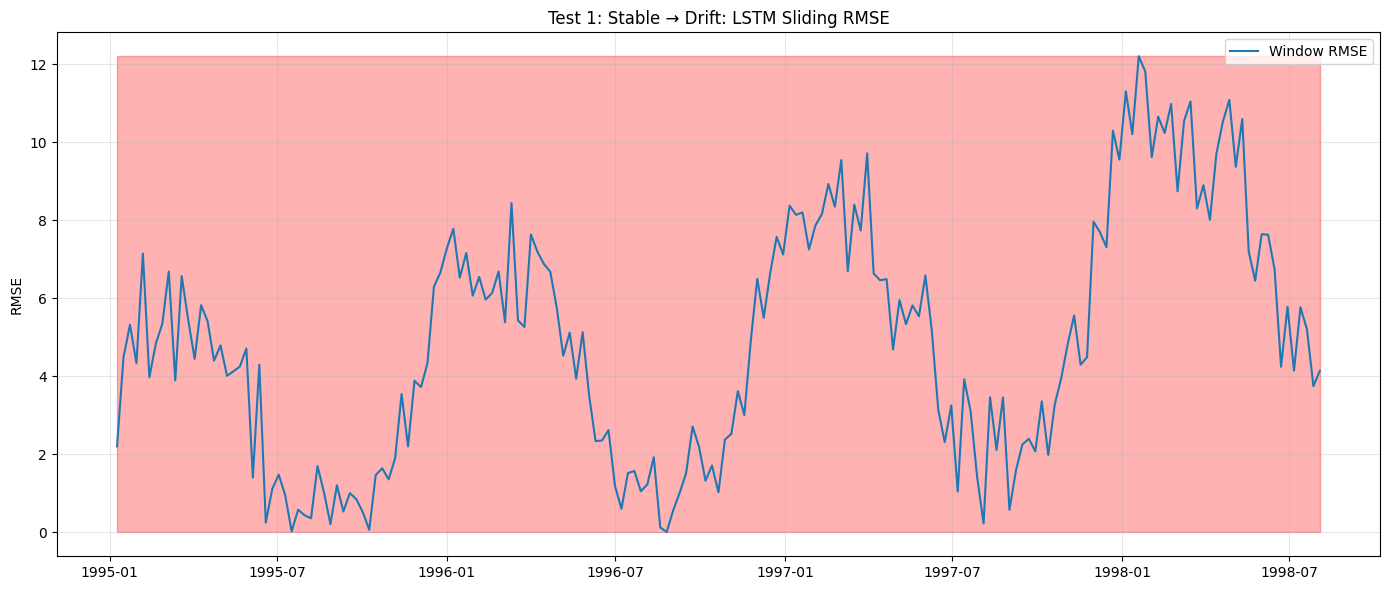

Stable RMSE: 1.371
Drift RMSE: 4.899
Robustness Ratio (Drift/Stable): 3.575


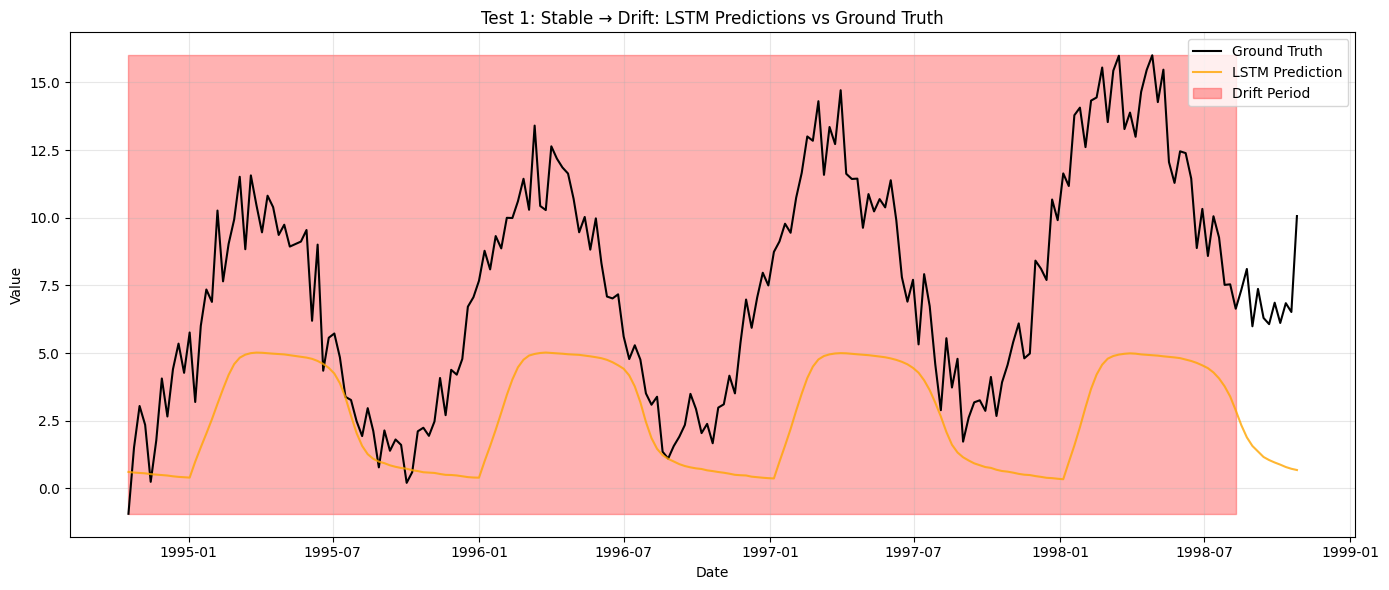


===== Test 2: Balanced Mix =====


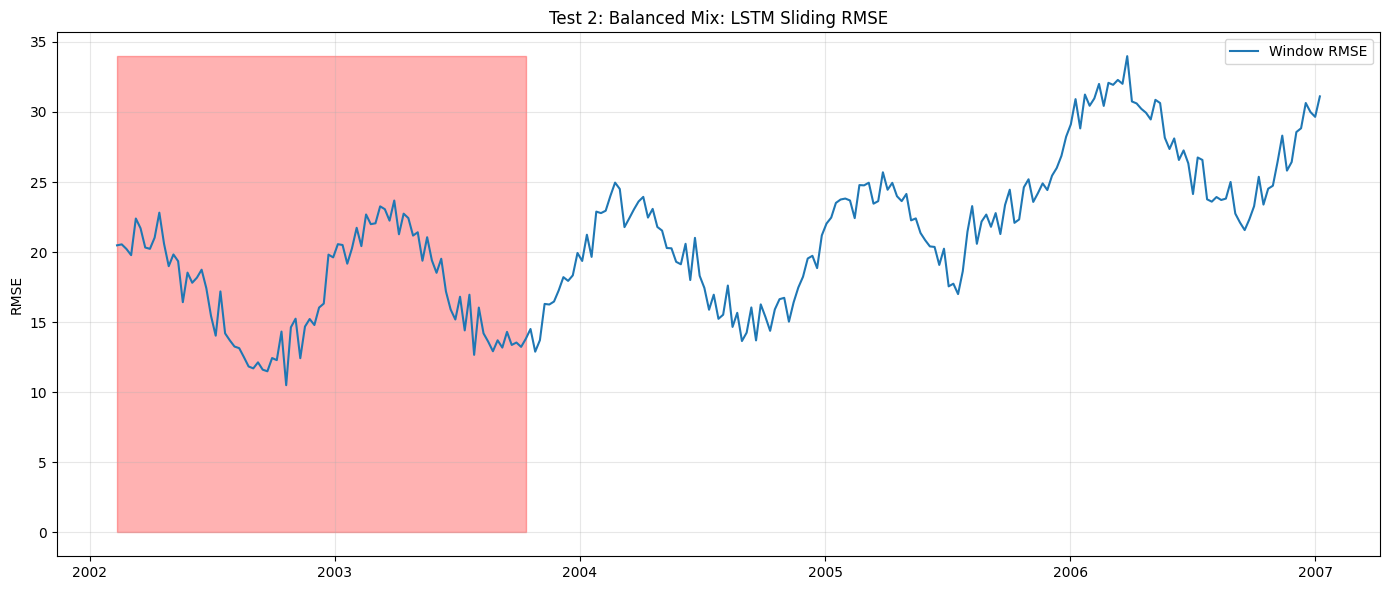

Stable RMSE: 22.857
Drift RMSE: 17.340
Robustness Ratio (Drift/Stable): 0.759


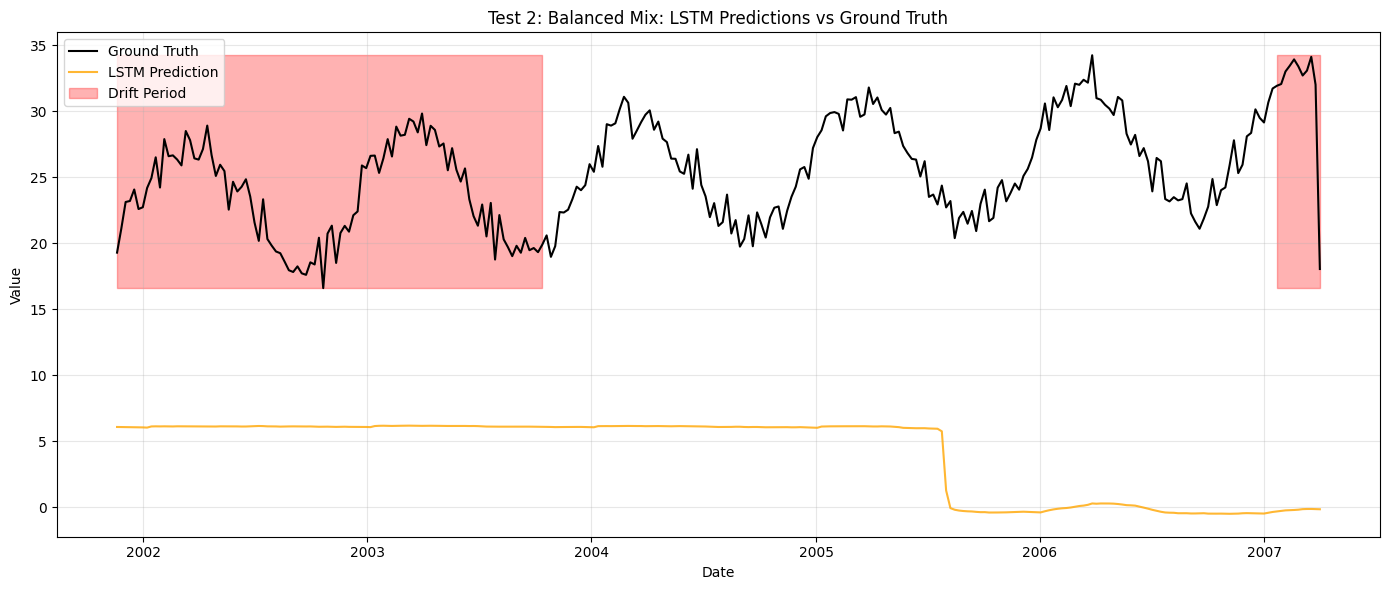


===== Test 3: Long Train, Short Inference =====


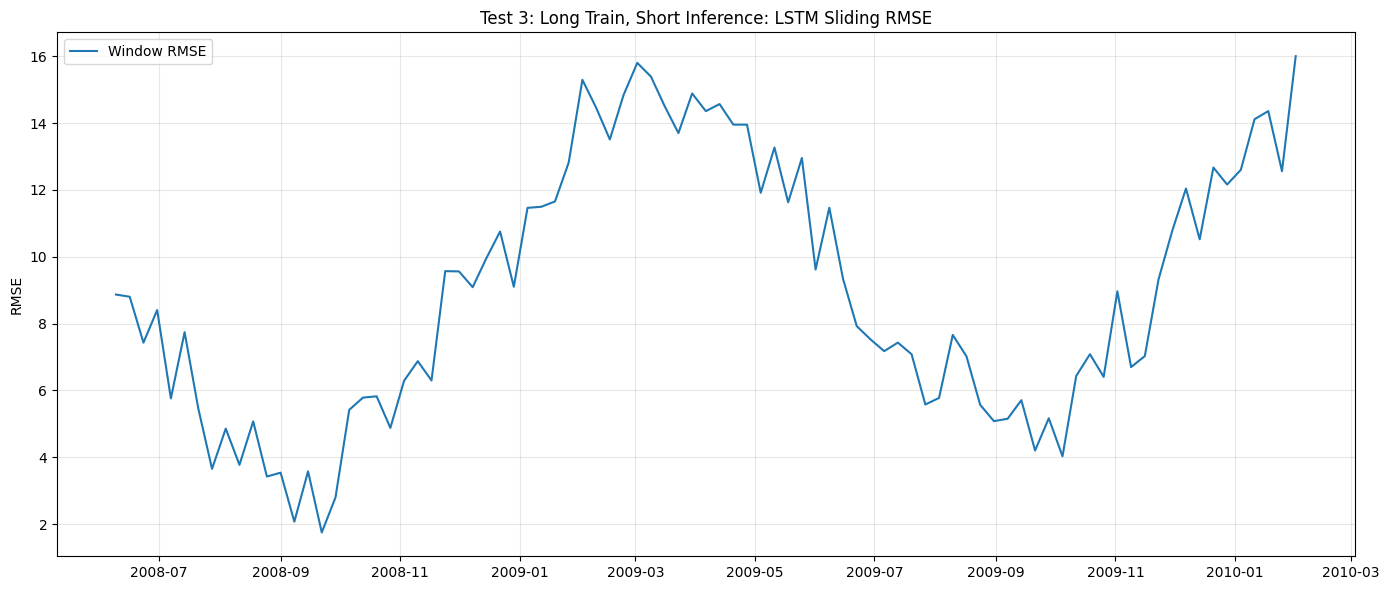

Stable RMSE: 8.977
Drift RMSE: 2.214
Robustness Ratio (Drift/Stable): 0.247


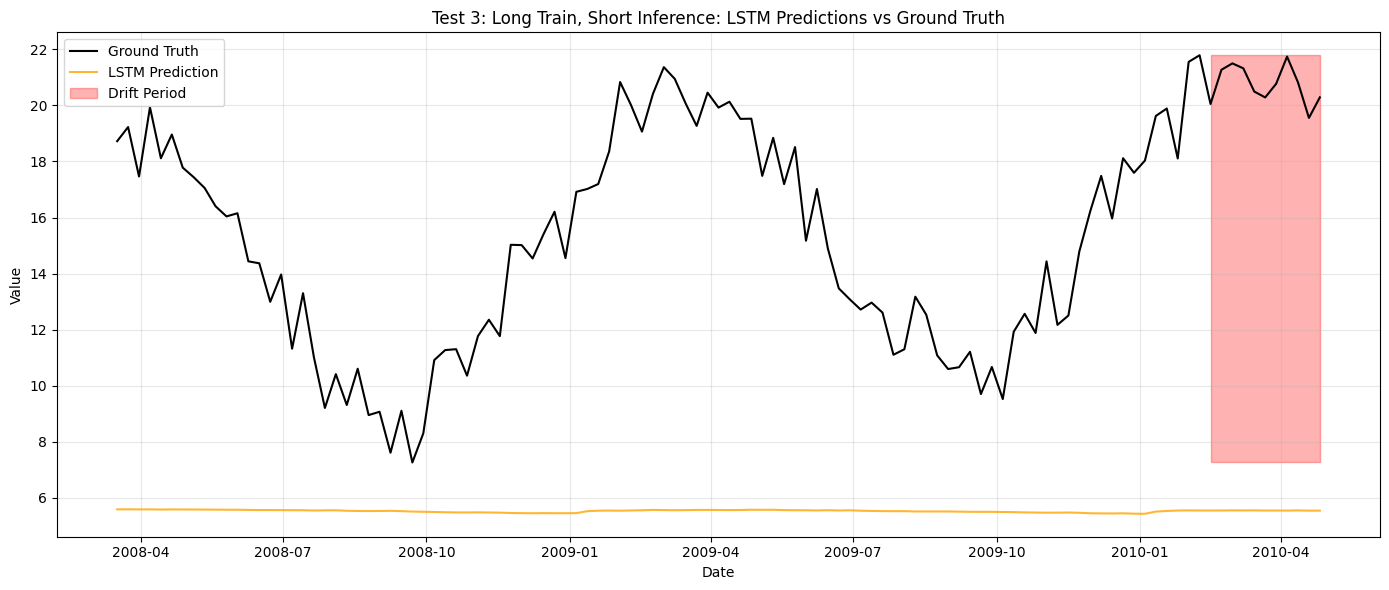


===== Test 4: Stable Only → Long Drift =====


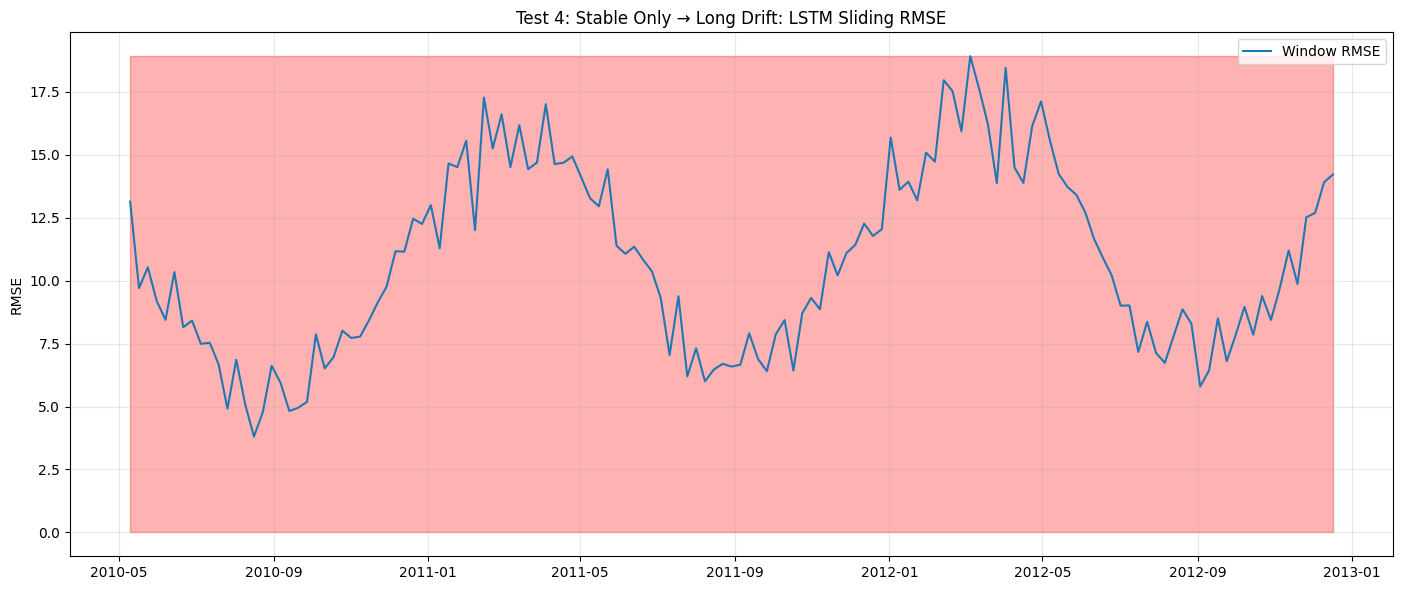

Stable RMSE: 1.548
Drift RMSE: 10.716
Robustness Ratio (Drift/Stable): 6.922


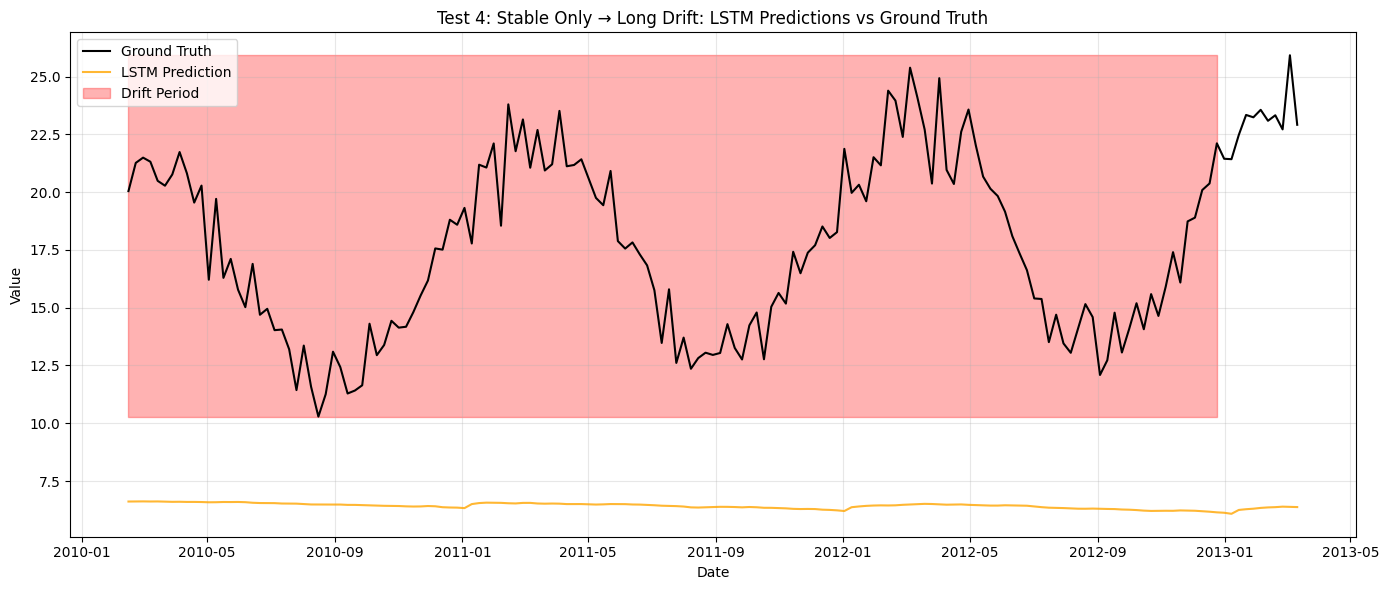


===== Test 5: Rolling Regimes =====


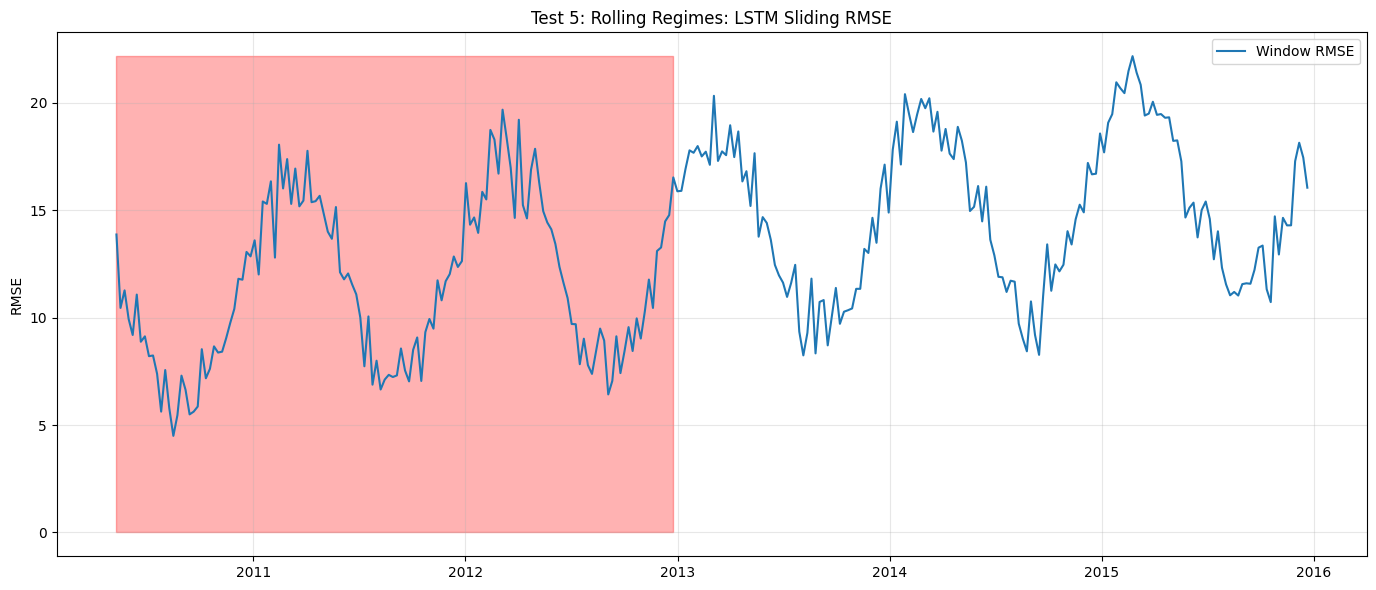

Stable RMSE: 15.036
Drift RMSE: 11.437
Robustness Ratio (Drift/Stable): 0.761


IndexError: index 1355 is out of bounds for axis 0 with size 1355

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ==== Step 1: Load and Prepare Data ====
df = pd.read_csv('../Data/simulateddata.csv', parse_dates=['date'], index_col='date')
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

# Lag Features
for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df.dropna(inplace=True)

# ==== Step 2: Define Model and Sequence Prep ====
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

# ==== Step 3: Evaluation Function ====
def run_lstm_test(test_name, train_start, train_end, infer_start, infer_end):
    print(f"\n===== {test_name} =====")

    target = 'var1'
    features = [col for col in df.columns if col not in [target, 'drift_period']]
    scaler = StandardScaler()
    X_all = scaler.fit_transform(df[features])
    y_all = df[target].values
    df['scaled_idx'] = np.arange(len(df))

    train_mask = (df.index >= train_start) & (df.index <= train_end)
    infer_mask = (df.index >= infer_start) & (df.index <= infer_end)

    train_idx = df[train_mask]['scaled_idx'].astype(int).values
    infer_idx = df[infer_mask]['scaled_idx'].astype(int).values

    X_train = X_all[train_idx]
    y_train = y_all[train_idx]

    SEQ_LEN = 12
    X_seq_train, y_seq_train = create_sequences(X_train, y_train, SEQ_LEN)

    model = LSTMModel(X_seq_train.shape[2])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_seq_train)
        loss = criterion(y_pred, y_seq_train)
        loss.backward()
        optimizer.step()

    # ==== Inference RMSE ====
    results = []
    for idx in range(infer_idx[0], infer_idx[-1] - SEQ_LEN):
        x_seq = torch.tensor(X_all[idx:idx+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
        y_true = y_all[idx + SEQ_LEN]
        y_pred = model(x_seq).item()
        rmse = np.sqrt((y_pred - y_true) ** 2)
        drift_flag = int(df.iloc[idx + SEQ_LEN]['drift_period'] > 0.5)
        date = df.index[idx + SEQ_LEN]
        results.append({'date': date, 'rmse': rmse, 'is_drift': drift_flag})

    results_df = pd.DataFrame(results).set_index('date')
    results_df['drift_flag'] = df.loc[results_df.index]['drift_period'].values
    stable_rmse = results_df[results_df['is_drift'] == 0]['rmse'].mean()
    drift_rmse = results_df[results_df['is_drift'] == 1]['rmse'].mean()

    # === Fallback estimation if no drift/stable regions in inference ===
    if np.isnan(stable_rmse):
        stable_block = train_idx[df.iloc[train_idx]['drift_period'].values == 0]
        if len(stable_block) >= SEQ_LEN + 1:
            x_test = torch.tensor(X_all[stable_block[0]:stable_block[0]+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
            y_true = y_all[stable_block[0] + SEQ_LEN]
            y_pred = model(x_test).item()
            stable_rmse = np.sqrt((y_pred - y_true) ** 2)

    if np.isnan(drift_rmse):
        drift_block = train_idx[df.iloc[train_idx]['drift_period'].values == 1]
        if len(drift_block) >= SEQ_LEN + 1:
            x_test = torch.tensor(X_all[drift_block[0]:drift_block[0]+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
            y_true = y_all[drift_block[0] + SEQ_LEN]
            y_pred = model(x_test).item()
            drift_rmse = np.sqrt((y_pred - y_true) ** 2)

    robustness_ratio = drift_rmse / stable_rmse if stable_rmse > 0 else float('nan')

    # ==== Plot RMSE Over Time ====
    plt.figure(figsize=(14, 6))
    plt.plot(results_df.index, results_df['rmse'], label='Window RMSE')
    plt.title(f'{test_name}: LSTM Sliding RMSE')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                 where=results_df['drift_flag'] > 0.5,
                 color='red', alpha=0.3, label='Drift Period')
    plt.show()

    print(f"Stable RMSE: {stable_rmse:.3f}")
    print(f"Drift RMSE: {drift_rmse:.3f}")
    print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")
   
    adjusted_start = infer_idx[0] - SEQ_LEN
    adjusted_end = infer_idx[-1]
    pred_vs_true = []
    for idx in range(adjusted_start, adjusted_end):
        x_seq = torch.tensor(X_all[idx:idx+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
        y_true = y_all[idx + SEQ_LEN]
        y_pred = model(x_seq).item()
        drift_flag = int(df.iloc[idx + SEQ_LEN]['drift_period'] > 0.5)
        date = df.index[idx + SEQ_LEN]
        pred_vs_true.append({'date': date, 'actual': y_true, 'predicted': y_pred, 'is_drift': drift_flag})

    pred_df = pd.DataFrame(pred_vs_true).set_index('date')
    pred_df = pred_df.join(df[['drift_period']], how='left')
    pred_df = pred_df.rename(columns={'drift_period': 'drift_flag'})
    pred_df['drift_flag'] = df.loc[pred_df.index]['drift_period'].values

    plt.figure(figsize=(14, 6))
    plt.plot(pred_df.index, pred_df['actual'], label='Ground Truth', color='black', linewidth=1.5)
    plt.plot(pred_df.index, pred_df['predicted'], label='LSTM Prediction', color='orange', alpha=0.8)
    plt.fill_between(pred_df.index,
                 pred_df['actual'].min(), pred_df['actual'].max(),
                 where=pred_df['drift_flag'] > 0.5,
                 color='red', alpha=0.3, label='Drift Period')
    plt.title(f'{test_name}: LSTM Predictions vs Ground Truth')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==== Step 4: Run All Evaluation Regimes ====
run_lstm_test("Test 1: Stable → Drift", "1990-01-01", "1994-10-10", "1994-10-17", "1998-08-10")
run_lstm_test("Test 2: Balanced Mix", "1994-10-17", "2001-11-12", "2001-11-19", "2007-01-15")
run_lstm_test("Test 3: Long Train, Short Inference", "1990-01-01", "2008-03-10", "2008-03-17", "2010-02-08")
run_lstm_test("Test 4: Stable Only → Long Drift", "1990-01-01", "2010-02-08", "2010-02-15", "2012-12-24")
run_lstm_test("Test 5: Rolling Regimes", "1990-01-01", "2010-02-08", "2010-02-15", "2015-12-28")


/var/tmp/ipykernel_32952/831530733.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)


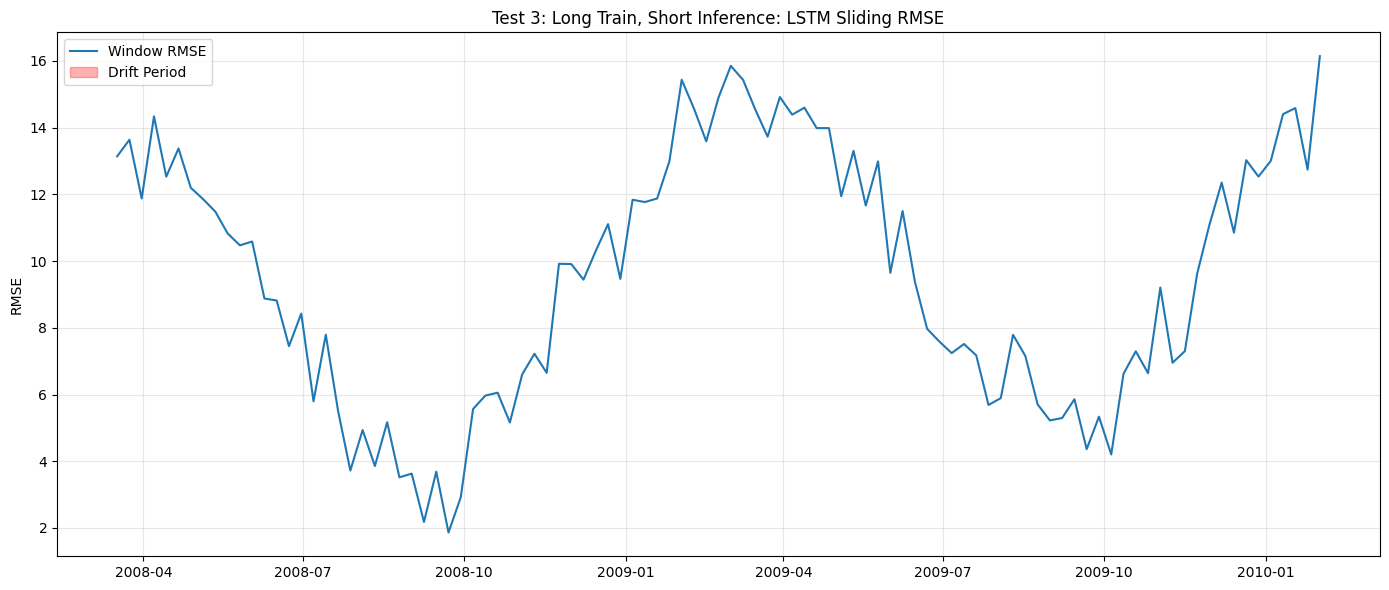

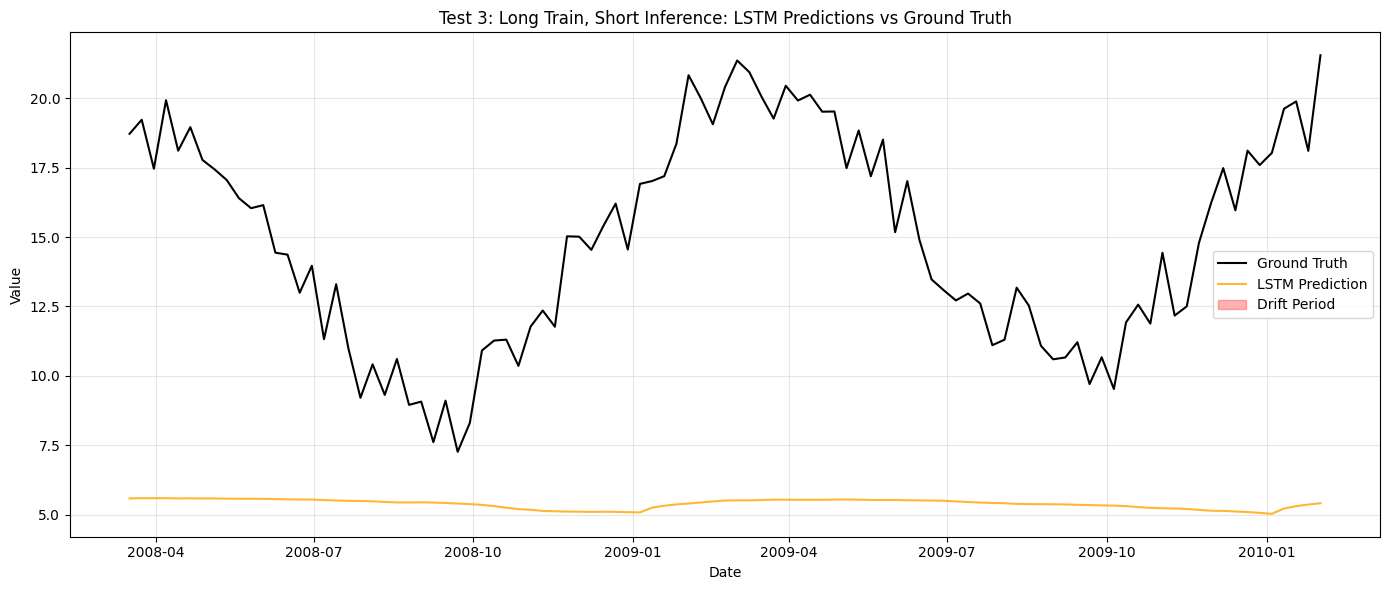

Stable RMSE: 9.506
Drift RMSE: nan
Robustness Ratio (Drift/Stable): nan


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../Data/simulateddata.csv', parse_dates=['date'], index_col='date')
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df.dropna(inplace=True)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

def run_lstm_test(test_name, train_start, train_end, infer_start, infer_end):
    target = 'var1'
    features = [col for col in df.columns if col not in [target, 'drift_period']]
    scaler = StandardScaler()
    X_all = scaler.fit_transform(df[features])
    y_all = df[target].values
    df['scaled_idx'] = np.arange(len(df))

    train_mask = (df.index >= train_start) & (df.index <= train_end)
    infer_mask = (df.index >= infer_start) & (df.index <= infer_end)

    train_idx = df[train_mask]['scaled_idx'].astype(int).values
    infer_idx = df[infer_mask]['scaled_idx'].astype(int).values

    X_train = X_all[train_idx]
    y_train = y_all[train_idx]

    SEQ_LEN = 12
    X_seq_train, y_seq_train = create_sequences(X_train, y_train, SEQ_LEN)

    model = LSTMModel(X_seq_train.shape[2])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_seq_train)
        loss = criterion(y_pred, y_seq_train)
        loss.backward()
        optimizer.step()

    adjusted_start = infer_idx[0] - SEQ_LEN
    adjusted_end = infer_idx[-1]
    results = []
    pred_vs_true = []
    for idx in range(adjusted_start, adjusted_end - SEQ_LEN):
        x_seq = torch.tensor(X_all[idx:idx+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
        y_true = y_all[idx + SEQ_LEN]
        y_pred = model(x_seq).item()
        date = df.index[idx + SEQ_LEN]
        results.append({'date': date, 'rmse': np.sqrt((y_pred - y_true) ** 2)})
        pred_vs_true.append({'date': date, 'actual': y_true, 'predicted': y_pred})

    results_df = pd.DataFrame(results).set_index('date')
    results_df = results_df.join(df[['drift_period']], how='left').rename(columns={'drift_period': 'drift_flag'})

    pred_df = pd.DataFrame(pred_vs_true).set_index('date')

    # Force datetime alignment using reset_index + merge to avoid misaligned index issues
    pred_df_reset = pred_df.reset_index()
    df_reset = df[['drift_period']].reset_index()

    # Merge on 'date'
    merged = pd.merge(pred_df_reset, df_reset, on='date', how='left')
    merged = merged.rename(columns={'drift_period': 'drift_flag'}).set_index('date')

    pred_df = merged.copy()


    stable_rmse = results_df[results_df['drift_flag'] <= 0.5]['rmse'].mean()
    drift_rmse = results_df[results_df['drift_flag'] > 0.5]['rmse'].mean()
    robustness_ratio = drift_rmse / stable_rmse if stable_rmse > 0 else float('nan')

    plt.figure(figsize=(14, 6))
    plt.plot(results_df.index, results_df['rmse'], label='Window RMSE')
    plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                     where=results_df['drift_flag'] > 0.5,
                     color='red', alpha=0.3, label='Drift Period')
    plt.title(f'{test_name}: LSTM Sliding RMSE')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    plt.plot(pred_df.index, pred_df['actual'], label='Ground Truth', color='black', linewidth=1.5)
    plt.plot(pred_df.index, pred_df['predicted'], label='LSTM Prediction', color='orange', alpha=0.8)
    plt.fill_between(pred_df.index,
                     pred_df['actual'].min(), pred_df['actual'].max(),
                     where=pred_df['drift_flag'] > 0.5,
                     color='red', alpha=0.3, label='Drift Period')
    plt.title(f'{test_name}: LSTM Predictions vs Ground Truth')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Stable RMSE: {stable_rmse:.3f}")
    print(f"Drift RMSE: {drift_rmse:.3f}")
    print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")

run_lstm_test("Test 3: Long Train, Short Inference", "1990-01-01", "2008-03-10", "2008-03-17", "2010-02-08")


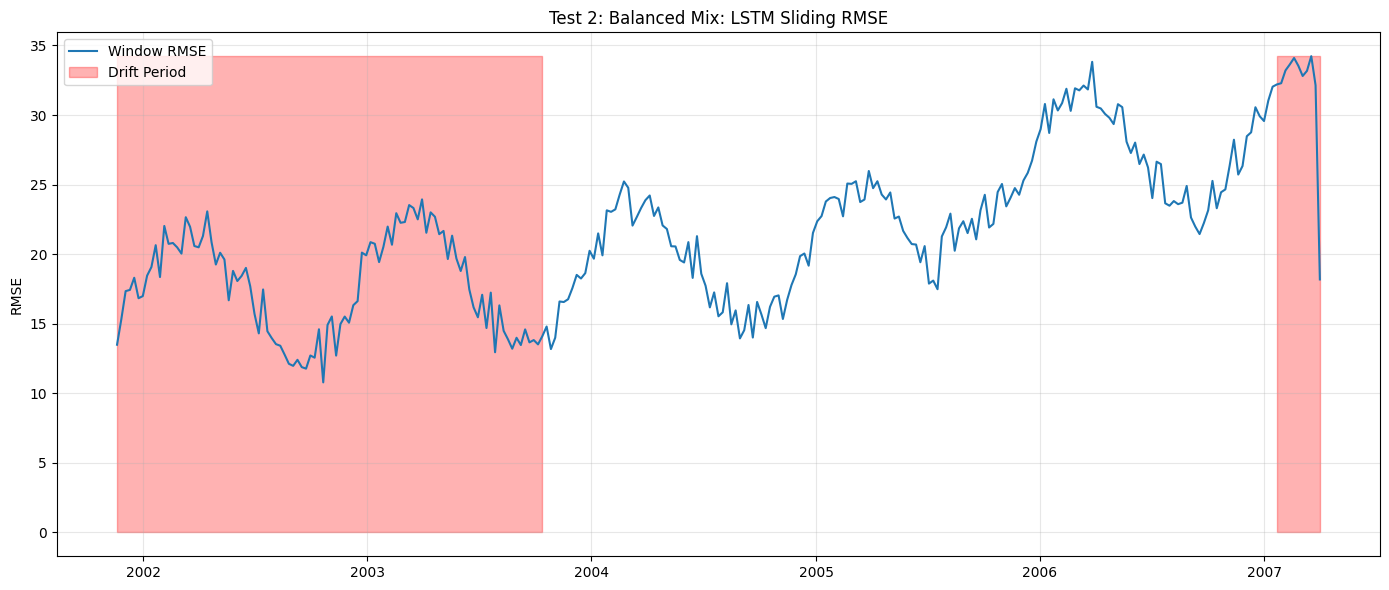

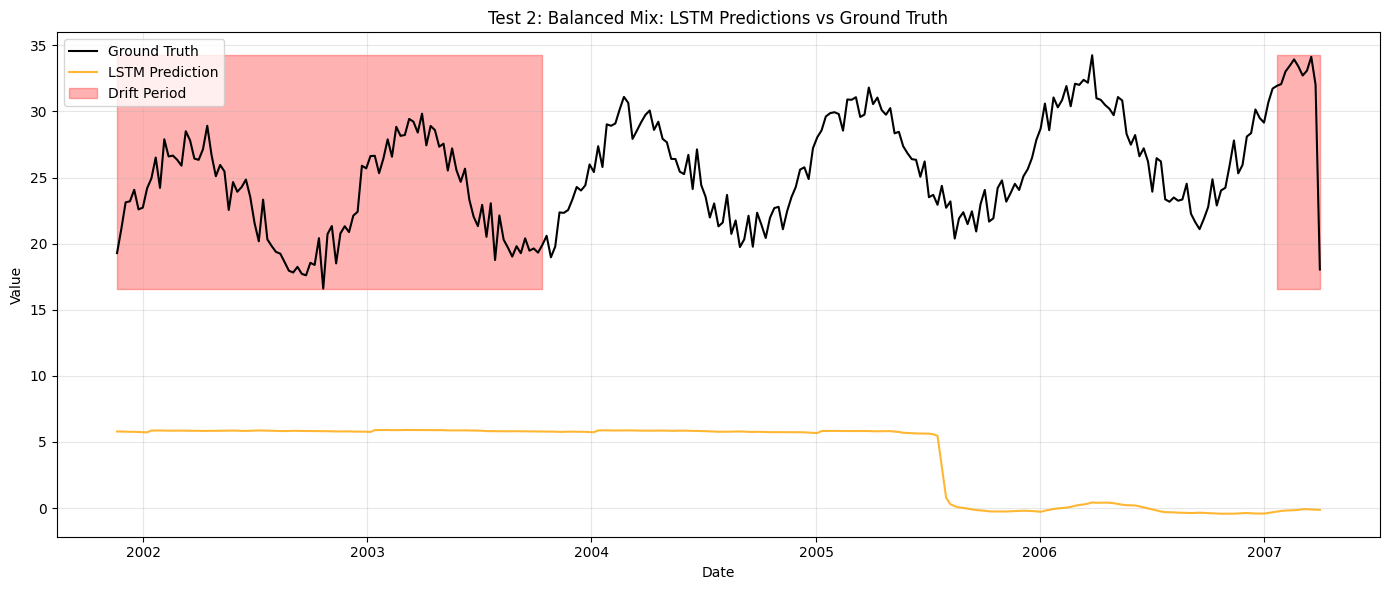

Stable RMSE: 23.030
Drift RMSE: 19.041
Robustness Ratio (Drift/Stable): 0.827


In [29]:
run_lstm_test("Test 2: Balanced Mix", "1994-10-17", "2001-11-12", "2001-11-19", "2007-01-15")


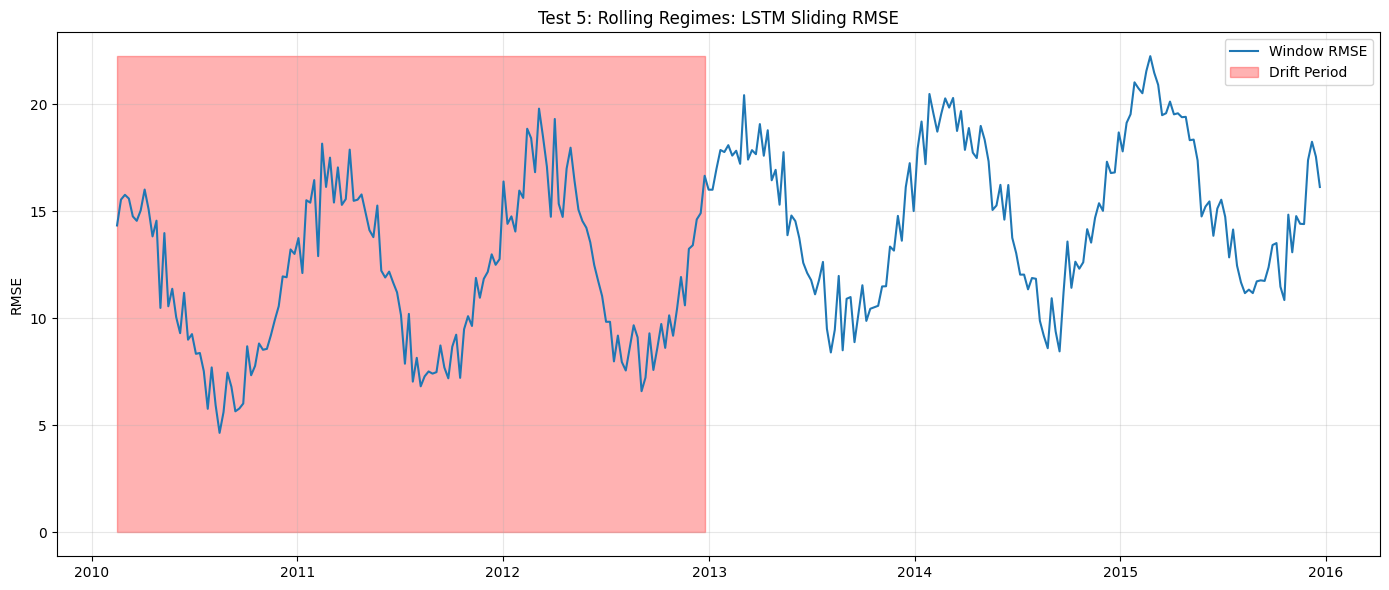

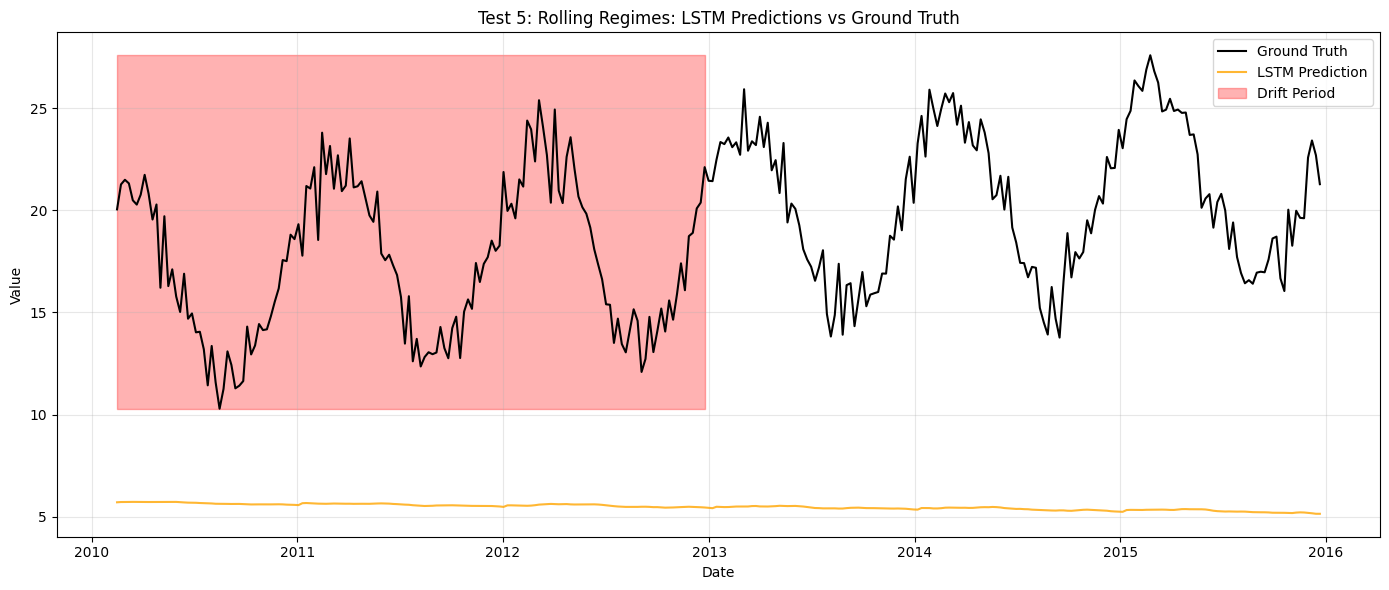

Stable RMSE: 15.165
Drift RMSE: 11.826
Robustness Ratio (Drift/Stable): 0.780


In [2]:
run_lstm_test("Test 5: Rolling Regimes", "1990-01-01", "2010-02-08", "2010-02-15", "2015-12-28")
